In [1]:
import os
clips_folder = "./dataset/data/clips/"
ordered_clips_folder = "./dataset/data/ordered_clips/"

# Vérifier si le répertoire existe
if not os.path.exists(ordered_clips_folder):
    os.makedirs(ordered_clips_folder)

In [2]:
import pandas as pd
import csv

# Spécifiez le chemin du fichier TSV
fichier_tsv = './dataset/train.tsv'

dataframe = pd.read_table(fichier_tsv)
# print(dataframe["client_id"])

dataframe.drop_duplicates(subset=["client_id"])
dataframe["client_id"].drop_duplicates()

client_ids = dataframe.groupby(["client_id"]).sum().reset_index()["client_id"]


In [3]:
import shutil
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


def process_audio_img(audio_path, destination_path):
    print("audio path:", audio_path)
    # Charger l'enregistrement audio
    y, sr = librosa.load(audio_path)

    # Calculer le spectrogramme avec les MEL spectrogrammes
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    # Convertir le spectrogramme en décibels (échelle logarithmique)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

    # Créer une nouvelle figure sans bordure autour du spectrogramme
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(spectrogram_db, x_axis="time", y_axis="mel")
    plt.axis("off")

    plt.savefig(destination_path, bbox_inches="tight", pad_inches=0)
    # plt.show()


In [4]:
def extract_audio_features(file_path):
    # Charger le fichier audio
    audio, sr = librosa.load(file_path)

    features = []

    # Calcul du ZCR

    chroma_stft = librosa.feature.chroma_stft(y=audio)
    features.append(np.mean(chroma_stft))
    features.append(np.var(chroma_stft))

    rms = librosa.feature.rms(y=audio)
    features.append(np.mean(rms))
    features.append(np.var(rms))

    # Calcul de la moyenne du Spectral centroid

    # spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
    spectral_centroids = librosa.feature.spectral_centroid(y=audio)
    features.append(np.mean(spectral_centroids))
    features.append(np.var(spectral_centroids))

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio)
    features.append(np.mean(spectral_bandwidth))
    features.append(np.var(spectral_bandwidth))

    rolloff = librosa.feature.spectral_rolloff(y=audio)
    features.append(np.mean(rolloff))
    features.append(np.var(rolloff))

    zcr = librosa.feature.zero_crossing_rate(y=audio)
    features.append(np.mean(zcr))
    features.append(np.var(zcr))

    harmony = librosa.effects.harmonic(y=audio)
    features.append(np.mean(harmony))
    features.append(np.var(harmony))

    tempo = librosa.feature.tempo(y=audio)
    features.append(tempo[0])

    # Calcul des moyennes des MFCC

    mfcc = librosa.feature.mfcc(y=audio)

    for x in mfcc:
        features.append(np.mean(x))
        features.append(np.var(x))

    return features


In [5]:
def extract_features(file_path):
    features = {}
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [6]:
# column_names = [
#                 'chroma_stft_mean','chroma_stft_var','rms_mean','rms_var',
#                 'spectral_centroid_mean','spectral_centroid_var','spectral_bandwidth_mean',
#                 'spectral_bandwidth_var','rolloff_mean','rolloff_var','zero_crossing_rate_mean',
#                 'zero_crossing_rate_var','harmony_mean','harmony_var', 'tempo',
#                 'mfcc1_mean','mfcc1_var','mfcc2_mean','mfcc2_var','mfcc3_mean','mfcc3_var',
#                 'mfcc4_mean','mfcc4_var','mfcc5_mean','mfcc5_var','mfcc6_mean','mfcc6_var','mfcc7_mean',
#                 'mfcc7_var','mfcc8_mean','mfcc8_var','mfcc9_mean','mfcc9_var','mfcc10_mean','mfcc10_var',
#                 'mfcc11_mean','mfcc11_var','mfcc12_mean','mfcc12_var','mfcc13_mean','mfcc13_var',
#                 'mfcc14_mean','mfcc14_var','mfcc15_mean','mfcc15_var','mfcc16_mean','mfcc16_var',
#                 'mfcc17_mean','mfcc17_var','mfcc18_mean','mfcc18_var','mfcc19_mean','mfcc19_var',
#                 'mfcc20_mean','mfcc20_var', 'label'
#             ]

column_names = ["label", "mfccs", "stft", "chroma", "mel", "contrast", "tonnetz"]
df = pd.DataFrame(columns=column_names)

counterRecord = 1


def read_rows_n_process_audio(rows, client_id):
    user_path = ordered_clips_folder + client_id
    if not os.path.exists(user_path):
        os.makedirs(user_path)

    turnRecord = 0
    for index, row in rows.iterrows():
        if turnRecord == 100:
            break
        clip_path = clips_folder + row["path"] + ".mp3"
        features = extract_audio_features(clip_path)

        print("feature len:", len(features))
        print("features:", features)
        df.loc[len(df)] = features + [client_id]

        # if not os.path.isfile(destination_path):
        # process_audio_img(clip_path, destination_path)

        turnRecord += 1


counter = 0
for client_id in client_ids:
    print("client:", counter)
    if counter == 10:
        break
    client_rows = dataframe[dataframe["client_id"] == client_id]
    read_rows_n_process_audio(client_rows, client_id)
    counter += 1

print("dataframe:", df)
df.to_csv("./librosa_processed_features.csv", index=False)

client: 0
feature len: 55
features: [0.42689192, 0.09286684, 0.05446843, 0.007070528, 2089.459112045283, 841817.7660775598, 2531.1794434716517, 631646.6133664765, 4860.422009184161, 7160712.796801294, 0.08061113430343511, 0.001698426437311243, -1.8720817e-05, 0.0018362432, 123.046875, -364.4127, 25386.672, 98.87653, 2742.417, 22.289598, 514.55365, 16.95533, 474.218, -2.547383, 594.3572, 1.2467363, 163.80591, 6.109837, 122.451294, 2.7364504, 148.90114, -4.12599, 193.63786, -1.7521966, 137.78044, 2.093756, 84.6719, 0.8589291, 123.61396, 3.7351215, 79.841515, 1.9797114, 46.738773, -7.102875, 100.70469, 2.715323, 63.421116, -0.734902, 85.08864, 0.04660826, 48.280228, -2.2584643, 38.278255, 4.35114, 45.72297]


ValueError: cannot set a row with mismatched columns

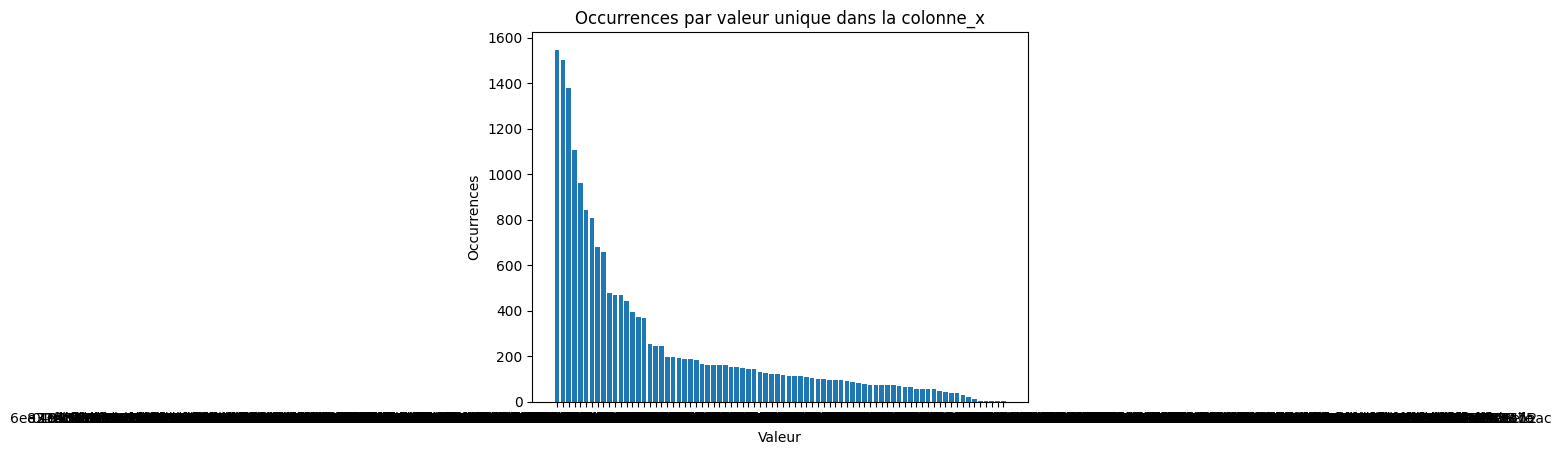

client_id
6ee71f12c50612a06eeac6b3eb87d7b1cd1440b1ae144d6a514fc0892cd62e9d9b8c67997c760fa48e868ade59d9474e3d3064d62f1358f53e87c4cd83544b17    1547
833dbf8db3b51edb501a34853f086ec3ee5212f97b03ab1a5b61ea814f57849ecfc2701d074e78f7c20ac84b51cdfd7affcb959d6798574ca288a85fbd275f3e    1500
049331a0346569d9b41738e0f31f495d097afc16eb54efc5f27518208f9c7ed004bb26d5a32fd6336a425b7768ffb3ead7a5fab8507ef2329be5e77359d6cee1    1379
1653ff7efc02d8f0e0d8be05adb19e1bfca543cee27730a522095473492bc9e3651c3f827725b8d4e4c57509f58ffccd0201d1bb4afb4136b9ab45e90b7f981d    1107
1e848413a3350d126cf0ce308fdae55242765ba6161db0d0efeff88d99a818dd3fd36c22fb7aaad27b09ef4a902f94578b46faf1c5e23f4a4b7933cf90bcb6d8     961
                                                                                                                                    ... 
55c51db25527451112209feed9c0fad23895ec66308ff9cafc4340c1497383389f5be5c53f3027c44bc81d8f9637b8e110a790083b53a56ff7582142fd0d7b73       4
1ff68ee41702f2d15314a0b063bae17

In [ ]:
import matplotlib.pyplot as plt
# Occurance 

occurances = dataframe["client_id"].value_counts()
# Créer un graphe à barres
plt.bar(occurances.index, occurances.values)

# Ajouter des étiquettes et un titre
plt.xlabel('Valeur')
plt.ylabel('Occurrences')
plt.title('Occurrences par valeur unique dans la colonne_x')

# Afficher le graphe
plt.show()

print(occurances)